<a href="https://colab.research.google.com/github/ljs7463/AnalysisProject/blob/master/%EB%8D%B0%EC%9D%B4%EC%BD%98/analytics/stacking2(stacking_custom).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00


# Import lib & load dataset

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화 폰트 설정
if os.name =='posix':
    plt.rc("font", family = "AppleGothic")

else:
    plt.rc("font", family = "Malgun Gothic")

# 경고문자 무시
warnings.filterwarnings(action='ignore')


# 데이터 로드
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')
df_info = pd.read_csv('data_info.csv')

# preprocessing & split dataset

In [16]:
## Label Encoding

## train데이터
df_train['preferred_difficulty_level'] = pd.factorize(df_train['preferred_difficulty_level'])[0]
df_train['subscription_type'] = pd.factorize(df_train['subscription_type'])[0]

## test데이터
df_test['preferred_difficulty_level'] = pd.factorize(df_test['preferred_difficulty_level'])[0]
df_test['subscription_type'] = pd.factorize(df_test['subscription_type'])[0]

# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_train[i] = scaler.fit_transform(df_train[i])
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_test[i] = scaler.transform(df_test[i])

# Delete user_id
df_train = df_train.drop(columns = 'user_id')

# split target
x = df_train[list(df_train.columns[:-1])]
y = df_train['target']

# Delete user_id
df_test = df_test.drop(columns = 'user_id')
# split target
new_x = df_test


## demension reduction

In [17]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis()
# x  = lda.fit_transform(x, y)
# new_x = lda.transform(new_x)

# Modeling

In [18]:
import optuna
from lightgbm import LGBMClassifier,early_stopping
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

## knn

In [19]:
# 목적 함수 정의

# 랜덤 시드 고정
np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

def obj_knn(trial,x,y):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
    score = cross_val_score(model, x, y, n_jobs=-1, cv=10, scoring='f1_macro')
    f1_macro = np.mean(score)

    return f1_macro

# Optuna 최적화 실행
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# lambda 함수를 사용하여 x와 y를 objective 함수에 전달
study.optimize(lambda trial: obj_knn(trial, x_train, y_train), n_trials = 100)


# 최적 파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적 파라미터로 모델 학습
best_params = study.best_trial.params
knn_model = KNeighborsClassifier(**best_params)

knn_model.fit(x_train, y_train)
y_test_pred = knn_model.predict(x_test)
f1_score(y_test, y_test_pred, average = 'macro')

Best trial:
  Value: 0.5098032215581101
  Params: 
    n_neighbors: 10
    metric: euclidean
    weights: uniform


0.5032003512854291

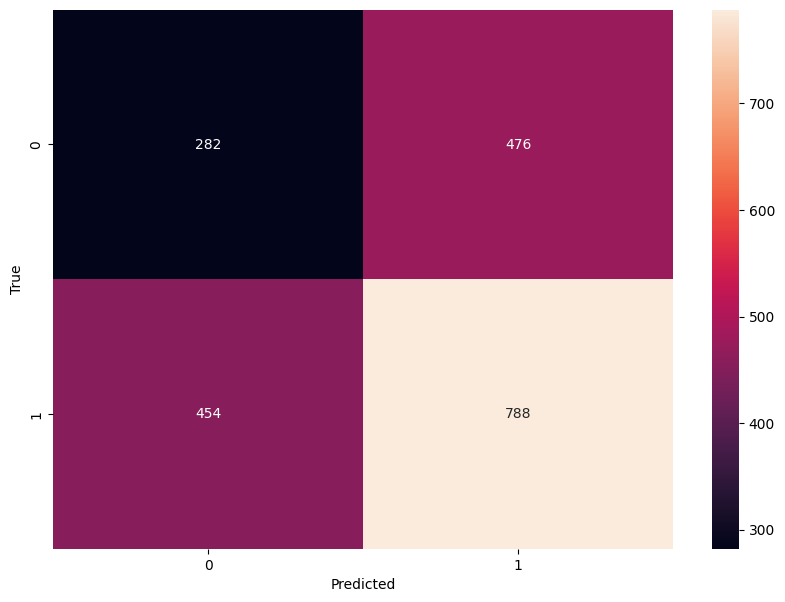

              precision    recall  f1-score   support

           0       0.38      0.37      0.38       758
           1       0.62      0.63      0.63      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.53      2000



In [20]:
# 혼동행렬
from sklearn.metrics import confusion_matrix
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_test_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 클래스별 성능 지표 출력
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

## lightGbm

In [11]:
from lightgbm import LGBMClassifier,early_stopping
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import load_iris
import pandas as pd

def objective(trial, x, y):
  # Optuna가 탐색할 하이퍼파라미터의 범위 설정
  params = {
        'objective': 'binary',
        'num_leaves': trial.suggest_int('num_leaves', 100, 500, step=1, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10, step=1, log=False),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 900, 1000, step=1, log=True),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=10, log=False),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'random_state': 0
  }

  # k-겹 교차 검증 설정
  kf = KFold(
      n_splits =10,
      shuffle = True,
      random_state = 42)
  f1_scores = []

  for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # xgBoost 모델생성
    model = LGBMClassifier(**params, n_jobs = -1)
    model.fit(x_train, y_train, eval_set = [(x_test, y_test)],callbacks=[early_stopping(stopping_rounds=100)], eval_metric= 'logloss')

    # 예측 및 F 점수 계산
    preds = model.predict(x_test)
    f1 = f1_score(y_test, preds, average = 'macro')
    f1_scores.append(f1)

  return np.mean(f1_scores)

# Optuna  스터디 생성 및 최적화 실행
study = optuna.create_study(direction = 'maximize')
# lambda 함수를 사용하여 x와 y를 objective 함수에 전달
study.optimize(lambda trial: objective(trial, x_train, y_train), n_trials = 60)

# 최적 하이퍼파라미터 출력
print('Best trial :', study.best_trial.params)



# Optuna 스터디에서 최적의 하이퍼파라미터 가져오기
best_params = study.best_trial.params

# 최적의 하이퍼파라미터를 사용하여 CatBoost 모델 초기화
lgbm_model = LGBMClassifier(**best_params, verbose=0)

# 전체 훈련 데이터셋을 사용하여 최종 모델 훈련
lgbm_model.fit(x_train, y_train)

# 테스트 데이터셋에 대한 예측 수행
predictions = lgbm_model.predict(x_test)
f1_score(y_test, y_test_pred, average = 'macro')


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

0.5032003512854291

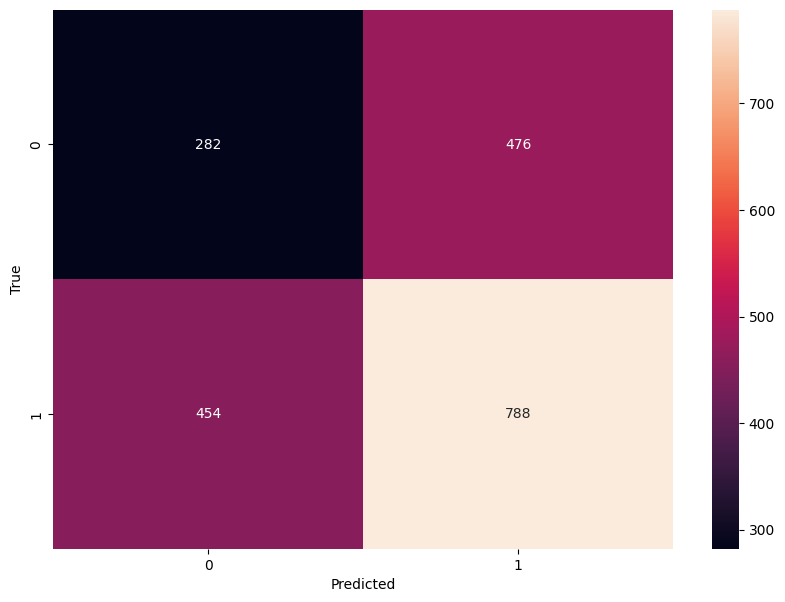

              precision    recall  f1-score   support

           0       0.38      0.37      0.38       758
           1       0.62      0.63      0.63      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.53      2000



In [12]:
# 혼동행렬
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_test_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 클래스별 성능 지표 출력
print(classification_report(y_test, y_test_pred))

# 전체실행

## SVM전체실행

In [ ]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화 폰트 설정
if os.name =='posix':
    plt.rc("font", family = "AppleGothic")

else:
    plt.rc("font", family = "Malgun Gothic")

# 경고문자 무시
warnings.filterwarnings(action='ignore')


# 데이터 로드
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')
df_info = pd.read_csv('data_info.csv')
## Label Encoding

## train데이터
df_train['preferred_difficulty_level'] = pd.factorize(df_train['preferred_difficulty_level'])[0]
df_train['subscription_type'] = pd.factorize(df_train['subscription_type'])[0]

## test데이터
df_test['preferred_difficulty_level'] = pd.factorize(df_test['preferred_difficulty_level'])[0]
df_test['subscription_type'] = pd.factorize(df_test['subscription_type'])[0]

# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_train[i] = scaler.fit_transform(df_train[i])
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_test[i] = scaler.transform(df_test[i])

# Delete user_id
df_train = df_train.drop(columns = 'user_id')

# split target
x = df_train[list(df_train.columns[:-1])]
y = df_train['target']

# Delete user_id
df_test = df_test.drop(columns = 'user_id')
# split target
new_x = df_test


import optuna
from lightgbm import LGBMClassifier,early_stopping
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


# 목적 함수 정의

# 랜덤 시드 고정
np.random.seed(42)

# 하이퍼파라미터 그리드 설정
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # 정규화 강도
    'gamma': [1, 0.1, 0.01, 0.001],  # 커널 계수
    'kernel': ['rbf', 'poly', 'sigmoid']  # 사용할 커널
}

# SVM 모델 생성
svm = SVC()

# GridSearchCV 객체 생성
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

# 그리드 서치 수행
grid_search_svm.fit(x_train, y_train)

# 최적의 파라미터와 점수 출력
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best cross-validation score for SVM: {:.2f}".format(grid_search_svm.best_score_))

# 최적 파라미터로 모델 학습
best_params_svm = grid_search_svm.best_params_
svm_model = SVC(**best_params_svm)

svm_model.fit(x_train, y_train)
y_test_pred_svm = svm_model.predict(x_test)
f1_score_svm = f1_score(y_test, y_test_pred_svm, average = 'macro')

# SVM 모델의 F1 점수 출력
print("F1 Score for SVM Model: {:.2f}".format(f1_score_svm))

# SVM 모델의 혼동 행렬
cm_svm = confusion_matrix(y_test, y_test_pred_svm)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM Model')
plt.show()

# SVM 모델의 클래스별 성능 지표 출력
print(classification_report(y_test, y_test_pred_svm))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


## knn전체실행

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Best cross-validation score: 0.51


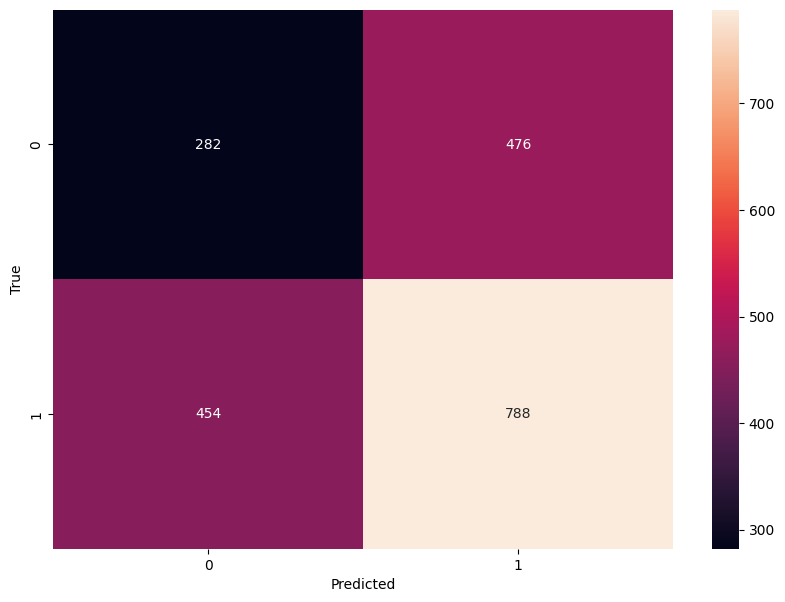

              precision    recall  f1-score   support

           0       0.38      0.37      0.38       758
           1       0.62      0.63      0.63      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.53      2000



In [1]:
!pip install catboost
!pip install optuna

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화 폰트 설정
if os.name =='posix':
    plt.rc("font", family = "AppleGothic")

else:
    plt.rc("font", family = "Malgun Gothic")

# 경고문자 무시
warnings.filterwarnings(action='ignore')


# 데이터 로드
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')
df_info = pd.read_csv('data_info.csv')


####################################################################

## Label Encoding

## train데이터
df_train['preferred_difficulty_level'] = pd.factorize(df_train['preferred_difficulty_level'])[0]
df_train['subscription_type'] = pd.factorize(df_train['subscription_type'])[0]

## test데이터
df_test['preferred_difficulty_level'] = pd.factorize(df_test['preferred_difficulty_level'])[0]
df_test['subscription_type'] = pd.factorize(df_test['subscription_type'])[0]

# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_train[i] = scaler.fit_transform(df_train[i])
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_test[i] = scaler.transform(df_test[i])

# Delete user_id
df_train = df_train.drop(columns = 'user_id')

# split target
x = df_train[list(df_train.columns[:-1])]
y = df_train['target']

# Delete user_id
df_test = df_test.drop(columns = 'user_id')
# split target
new_x = df_test


####################################################################


import optuna
from lightgbm import LGBMClassifier,early_stopping
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


# 목적 함수 정의

# 랜덤 시드 고정
np.random.seed(42)
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def obj_knn(trial,x,y):
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
#     metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
#     weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

#     model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
#     score = cross_val_score(model, x, y, n_jobs=-1, cv=10, scoring='f1_macro')
#     f1_macro = np.mean(score)

#     return f1_macro

# # Optuna 최적화 실행
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# # lambda 함수를 사용하여 x와 y를 objective 함수에 전달
# study.optimize(lambda trial: obj_knn(trial, x_train, y_train), n_trials = 100)


# # 최적 파라미터 출력
# print("Best trial:")
# trial = study.best_trial
# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

# # 최적 파라미터로 모델 학습
# best_params = study.best_trial.params
# knn_model = KNeighborsClassifier(**best_params)

# knn_model.fit(x_train, y_train)
# y_test_pred = knn_model.predict(x_test)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

# KNN 모델 생성
knn = KNeighborsClassifier()

# GridSearchCV 객체 생성
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=1)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 파라미터와 점수 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# 최적 파라미터로 모델 학습
best_params = grid_search.best_params_
knn_model = KNeighborsClassifier(**best_params)

knn_model.fit(x_train, y_train)
y_test_pred = knn_model.predict(x_test)
f1_score(y_test, y_test_pred, average = 'macro')


#############################################################################
# 혼동행렬
from sklearn.metrics import confusion_matrix
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_test_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 클래스별 성능 지표 출력
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

In [3]:
pd.DataFrame(y_test_pred)

,0
0,1
1,0
2,1
3,1
4,1
...,...
1995,1
1996,0
1997,1
1998,1


# lgbm 전체실행

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

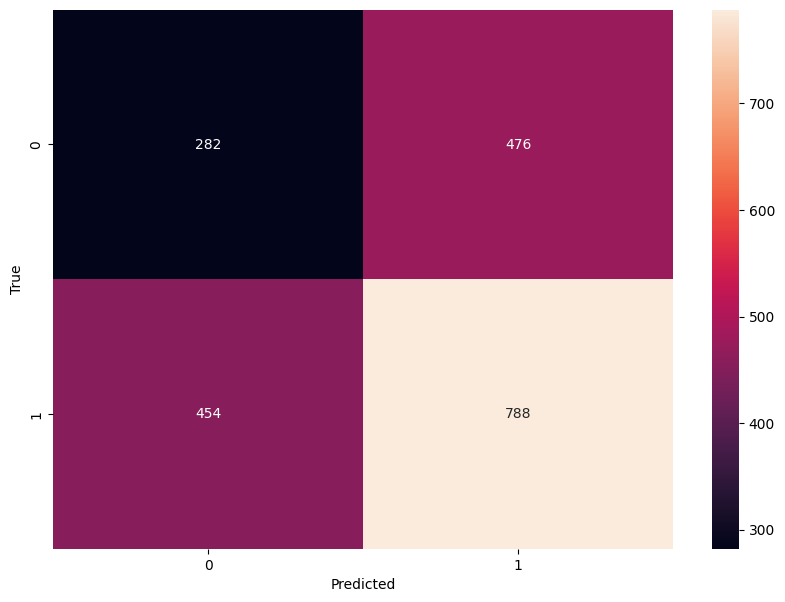

              precision    recall  f1-score   support

           0       0.38      0.37      0.38       758
           1       0.62      0.63      0.63      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.53      2000



In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화 폰트 설정
if os.name =='posix':
    plt.rc("font", family = "AppleGothic")

else:
    plt.rc("font", family = "Malgun Gothic")

# 경고문자 무시
warnings.filterwarnings(action='ignore')


# 데이터 로드
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')
df_info = pd.read_csv('data_info.csv')


####################################################################

## Label Encoding

## train데이터
df_train['preferred_difficulty_level'] = pd.factorize(df_train['preferred_difficulty_level'])[0]
df_train['subscription_type'] = pd.factorize(df_train['subscription_type'])[0]

## test데이터
df_test['preferred_difficulty_level'] = pd.factorize(df_test['preferred_difficulty_level'])[0]
df_test['subscription_type'] = pd.factorize(df_test['subscription_type'])[0]

# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_train[i] = scaler.fit_transform(df_train[i])
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_test[i] = scaler.transform(df_test[i])

# Delete user_id
df_train = df_train.drop(columns = 'user_id')

# split target
x = df_train[list(df_train.columns[:-1])]
y = df_train['target']

# Delete user_id
df_test = df_test.drop(columns = 'user_id')
# split target
new_x = df_test


####################################################################


import optuna
from lightgbm import LGBMClassifier,early_stopping
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)



###################################################################


from lightgbm import LGBMClassifier,early_stopping
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import load_iris
import pandas as pd

def objective(trial, x, y):
  # Optuna가 탐색할 하이퍼파라미터의 범위 설정
  params = {
        'objective': 'binary',
        'num_leaves': trial.suggest_int('num_leaves', 100, 500, step=1, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10, step=1, log=False),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 900, 1000, step=1, log=True),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=10, log=False),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'random_state': 0
  }

  # k-겹 교차 검증 설정
  kf = KFold(
      n_splits =10,
      shuffle = True,
      random_state = 42)
  f1_scores = []

  for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # xgBoost 모델생성
    model = LGBMClassifier(**params, n_jobs = -1)
    model.fit(x_train, y_train, eval_set = [(x_test, y_test)],callbacks=[early_stopping(stopping_rounds=100)], eval_metric= 'logloss')

    # 예측 및 F 점수 계산
    preds = model.predict(x_test)
    f1 = f1_score(y_test, preds, average = 'macro')
    f1_scores.append(f1)

  return np.mean(f1_scores)

# Optuna  스터디 생성 및 최적화 실행
study = optuna.create_study(direction = 'maximize')
# lambda 함수를 사용하여 x와 y를 objective 함수에 전달
study.optimize(lambda trial: objective(trial, x_train, y_train), n_trials = 60)

# 최적 하이퍼파라미터 출력
print('Best trial :', study.best_trial.params)



# Optuna 스터디에서 최적의 하이퍼파라미터 가져오기
best_params = study.best_trial.params

# 최적의 하이퍼파라미터를 사용하여 CatBoost 모델 초기화
lgbm_model = LGBMClassifier(**best_params, verbose=0)

# 전체 훈련 데이터셋을 사용하여 최종 모델 훈련
lgbm_model.fit(x_train, y_train)

# 테스트 데이터셋에 대한 예측 수행
predictions = lgbm_model.predict(x_test)
f1_score(y_test, y_test_pred, average = 'macro')

###############################################################################

# 혼동행렬
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_test_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 클래스별 성능 지표 출력
print(classification_report(y_test, y_test_pred))